# Anime ETL - Fact

In [1]:
config_file = '../config.json'

importing and read config files

In [2]:
import json
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

with open(config_file) as f:
    config = json.load(f)
    mongo_cred = config['MongoDB']

create a MongoDB connection to read data from MyAnimeList db

In [3]:
connection_string = f"mongodb+srv://{mongo_cred['username']}:{mongo_cred['password']}@{mongo_cred['database']}.{mongo_cred['cluster']}.mongodb.net/"
client = pymongo.MongoClient(connection_string)
db = client['MyAnimeList']

read stg_anime_details collection and save documents in a list in order to create a pandas DataFrame

In [4]:
stg_jsons = db.stg_anime_details.find({})
anime_details = []
for anime_detail in stg_jsons:
    anime_details.append(anime_detail)
df_anime = pd.DataFrame(anime_details)

load a csv file with genres grouped in 13 main genres

In [14]:
genres_mapping = pd.read_csv('../data/stg/genre_mapping.csv', header=0)
genres_mapping_json = genres_mapping.to_dict(orient='records')

create a function to "clear" anime genres from superfluous genres

In [9]:
def define_main_genres(row:list, genres_json_list:list) -> list:
    """Function to define the main genres of an anime based on the genres list and the genre mapping
    Args:
        row (list): row of the dataframe
        genres_json_list (list): list of dictionaries with the genre mapping
    Returns:
        list: list with the main genres (without duplicates)
    """
    new_genres = []
    genres_list = row['genres']
    for genre in genres_list:
        for el in genres_json_list:
            if el['genre_name'] == genre:
                current_genre = el['genre_category']
                if current_genre not in new_genres:
                    new_genres.append(current_genre)
    return new_genres
df_anime['main_genres'] = df_anime.apply(lambda row: define_main_genres(row, genres_mapping_json), axis = 1)

In [13]:
df_anime.sample(5)

,_id,title,start_date,end_date,vote,rank,num_scoring_users,updated_at,media_type,status,...,num_episode,source,audience_rating,studios,watching,completed,on_hold,dropped,plan_to_watch,main_genres
8375,832,Ginsoukikou Ordian,2000-04-04,2000-09-19,5.62,11159,1008,2022-03-22T02:30:57+00:00,tv,finished_airing,...,24,original,r+,[Plum],245,1222,159,237,2078,"[Action, Sci-Fi]"
2000,7244,Japanese-English Pictionary,1989,1989,5.23,12338,489,2011-05-23T01:07:19+00:00,movie,finished_airing,...,1,None,g,"[Yamamura Animation, Inc.]",25,703,11,42,228,[Comedy]
5,39979,Business Fish,2019-07-08,2019-08-12,5.31,12144,723,2021-12-11T22:29:21+00:00,tv,finished_airing,...,6,original,pg_13,[],302,560,259,521,2194,"[Comedy, Drama, Action]"
38,4131,Twin Bee Paradise,1998-12-18,1999-04-25,5.91,9967,488,2023-08-02T02:05:32+00:00,ova,finished_airing,...,4,game,g,[],59,563,24,70,400,"[Action, Adventure]"
772,39282,Beyblade Burst Rise,2019-04-05,2020-03-27,6.23,8308,5500,2024-03-06T10:56:57+00:00,tv,finished_airing,...,52,manga,pg,[OLM],855,6630,287,700,2303,"[Action, Adventure, Kids, Sci-Fi]"


uniforming date columns as yyyy-mm-yy

In [14]:
#transform date columns into date format
df_anime['start_date'] = pd.to_datetime(df_anime['start_date'], yearfirst = True, format = 'mixed').dt.date
df_anime['end_date'] = pd.to_datetime(df_anime['end_date'], yearfirst = True, format = 'mixed').dt.date
df_anime['updated_at'] = pd.to_datetime(df_anime['updated_at'], yearfirst = True, format = 'mixed').dt.date

check if the minimun date could be right

In [15]:
df_anime[df_anime['start_date'] == df_anime['start_date'].min()]

,_id,title,start_date,end_date,vote,rank,num_scoring_users,updated_at,media_type,status,...,num_episode,source,audience_rating,studios,watching,completed,on_hold,dropped,plan_to_watch,main_genres
621,30298,Mahou no Princess Minky Momo: Yume wo Dakishim...,1900-01-01,1900-01-01,6.11,8973,408,2023-09-18,special,finished_airing,...,3,None,g,[Ashi Productions],49,541,13,80,306,[Fantasy]
4459,30159,Super Taromu,1900-01-01,1900-01-01,5.20,12385,124,2023-06-04,special,finished_airing,...,1,None,g,[Knack Productions],12,173,7,50,79,[Action]
4608,39102,Transformers: Choujin Master Force Soushuuhen,1900-01-01,1900-01-01,5.69,10917,115,2019-02-02,ova,finished_airing,...,4,other,g,[],34,179,13,52,173,"[Action, Sci-Fi]"
5318,30840,Many Things SD Gundam,1900-01-01,2011-07-22,5.02,12677,329,2021-07-09,special,finished_airing,...,2,original,pg_13,[Sunrise],54,521,41,95,457,"[Comedy, Action]"
8613,50740,Hanako,1900-01-01,1900-01-01,5.71,10863,1088,2022-01-15,movie,finished_airing,...,1,original,pg_13,[],26,1500,9,15,238,"[Kids, Sci-Fi]"
10009,23711,Kakumei no Wakaki Sora,1900-01-01,1900-01-01,6.27,8106,226,2014-04-23,ova,finished_airing,...,1,None,g,[],26,382,10,57,207,[Drama]


manage missing date (set on 1900-01-01) imputing correct value searched on web, 3 missing date are not available on web, so delete the rows

In [16]:

df_anime.loc[df_anime['title'] == 'Mahou no Princess Minky Momo: Yume wo Dakishimete Specials', 'start_date'] = pd.to_datetime('1982-03-18').date()
df_anime.loc[df_anime['title'] == 'Mahou no Princess Minky Momo: Yume wo Dakishimete Specials', 'end_date'] = pd.to_datetime('1983-05-26').date()

df_anime.loc[df_anime['title'] == 'Super Taromu', 'start_date'] = pd.to_datetime('1972-01-01').date()
df_anime.loc[df_anime['title'] == 'Super Taromu', 'end_date'] = pd.to_datetime('1972-01-01').date()

df_anime.loc[df_anime['title'] == 'Transformers: Choujin Master Force Soushuuhen', 'start_date'] = pd.to_datetime('1988-04-12').date()
df_anime.loc[df_anime['title'] == 'Transformers: Choujin Master Force Soushuuhen', 'end_date'] = pd.to_datetime('1989-02-28').date()

df_anime = df_anime[df_anime['start_date'] != pd.to_datetime('1900-01-01').date()]
df_anime = df_anime[df_anime['end_date'] != pd.to_datetime('1900-01-01').date()]

check missing value

In [17]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11637 entries, 0 to 11714
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                11637 non-null  int64  
 1   title              11637 non-null  object 
 2   start_date         11637 non-null  object 
 3   end_date           11637 non-null  object 
 4   vote               11637 non-null  float64
 5   rank               11637 non-null  int64  
 6   num_scoring_users  11637 non-null  int64  
 7   updated_at         11637 non-null  object 
 8   media_type         11637 non-null  object 
 9   status             11637 non-null  object 
 10  synopsis           11637 non-null  object 
 11  genres             11637 non-null  object 
 12  num_episode        11637 non-null  int64  
 13  source             10795 non-null  object 
 14  audience_rating    11637 non-null  object 
 15  studios            11637 non-null  object 
 16  watching           11637 no

analyse source both for missing value and low count values

In [ ]:
df_anime['source'].value_counts()

manage missing source value with the value "other"

In [ ]:
df_anime.loc[df_anime['source'].isnull(), 'source'] = 'other'

grouping similar sources

In [ ]:
def define_source(row:str) -> str:
    """Function to define the source of the anime
    Args:
        row (str): row of the dataframe
    Returns:
        str: source of the anime
    """
    source = row['source']
    if source in ['light_novel', 'novel', 'visual_novel', 'web_novel']:
        out_source = 'novel'
    elif source in ['manga', 'web_manga', '4_koma_manga']:
        out_source = 'manga'
    elif source in ['game', 'card_game']:
        out_source = 'game'
    elif source in ['book', 'picture_book']:
        out_source = 'book'
    else:
        out_source = source
    return out_source
df_anime['inspired_by'] = df_anime.apply(lambda row: define_source(row), axis = 1)

analyse media_type

In [ ]:
df_anime['media_type'].value_counts()

tv : tv
ova : original video animation
movie : movie
special : special
ona : original net animation (no tv, only web)
tv_special : tv special

exclude 3 rows with souspicious values

In [ ]:
df_anime = df_anime[~df_anime['media_type'].isin(['unknown', 'pv', 'cm'])]

analyse audience_rating

In [ ]:
df_anime['audience_rating'].value_counts()

g: general, no restriction
pg : parental guidance suggested
pg_13 : teens 13 or older
r : 17+ recommended
r_plus : mild nudity
rx : explicit nudity => exclude
ur : unrated

exclude 1 row with explicit nudity

In [ ]:
df_anime = df_anime[~df_anime['audience_rating'].isin(['rx'])]

create a function to group audience_rating in a new feature call min_age (minimum age)

In [ ]:
def age_rating(row:str) -> int:
    """Function to define the minimum age for a given audience rating
    Args:
        row (str): audience rating
    Returns:
        int: minimum age
    """
    min_age = 0
    if row == 'pg_13':
        min_age = 13
    elif row == 'pg':
        min_age = 10
    elif row == 'r':
        min_age = 18
    elif row == 'r+':
        min_age = 18
    elif row == 'ur':
        min_age = 18
    return min_age

df_anime['min_age'] = df_anime['audience_rating'].map(lambda row: age_rating(row))

transform column with numbers into numeric fields

In [ ]:
df_anime['watching'] = pd.to_numeric(df_anime['watching'])
df_anime['completed'] = pd.to_numeric(df_anime['completed'])
df_anime['on_hold'] = pd.to_numeric(df_anime['on_hold'])
df_anime['dropped'] = pd.to_numeric(df_anime['dropped'])
df_anime['plan_to_watch'] = pd.to_numeric(df_anime['plan_to_watch'])

check stats on numeric columns

In [28]:
round(df_anime.describe(),2)

,_id,vote,rank,num_scoring_users,num_episode,watching,completed,on_hold,dropped,plan_to_watch,min_age
count,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00,11633.00
mean,21919.15,6.61,6227.64,42641.74,13.99,5180.78,53726.99,2075.66,2616.16,18790.97,11.09
std,17792.24,0.90,3813.70,142579.39,52.78,18068.88,175948.12,6938.94,7962.62,41997.21,5.97
min,1.00,1.86,1.00,105.00,0.00,5.00,4.00,0.00,7.00,22.00,0.00
25%,4793.00,6.01,2948.00,630.00,1.00,87.00,844.00,44.00,98.00,649.00,10.00
50%,17961.00,6.66,5892.00,3404.00,4.00,349.00,4542.00,182.00,215.00,3044.00,13.00
75%,37304.00,7.26,9469.00,22803.00,13.00,2110.00,29906.00,1037.00,1105.00,14917.00,13.00
max,59094.00,9.35,13345.00,2813984.00,3057.00,497550.00,3484507.00,185547.00,214191.00,646619.00,18.00


rows with 0 episodes, check them

In [29]:
df_anime[df_anime['num_episode'] == 0]

,_id,title,start_date,end_date,vote,rank,num_scoring_users,updated_at,media_type,status,...,audience_rating,studios,watching,completed,on_hold,dropped,plan_to_watch,main_genres,inspired_by,min_age
1484,57487,Rising Impact,2024-06-22,2024-08-06,6.92,4547,304,2024-03-23,ona,currently_airing,...,pg_13,[Lay-duce],674,28,51,36,1562,"[Adventure, Action]",manga,13
8482,56840,T.P BON,2024-05-02,2024-07-17,6.93,4490,1081,2024-05-11,ona,currently_airing,...,r,[Bones],1955,8,323,240,3229,"[Action, Adventure, Drama, Sci-Fi, Fantasy]",manga,18


manage missing number of episodes imputing correct value searched on web

In [30]:
df_anime.loc[df_anime['title'] == 'Rising Impact', 'num_episode'] = 12
df_anime.loc[df_anime['title'] == 'T.P BON', 'num_episode'] = 24

create the core metrics of the analysis: the final score

let's begin with the score as the sum of users weighted with the medium vote of the anime or a fixed value based on user's behaviour

In [ ]:
df_anime['score'] = (
    df_anime['vote'] * df_anime['num_scoring_users'] +
    6 * df_anime['watching'] +
    8 * df_anime['completed'] +
    5.5* df_anime['on_hold'] +
    (1) * df_anime['dropped'] +
    (4) * df_anime['plan_to_watch']
)

check score distribution

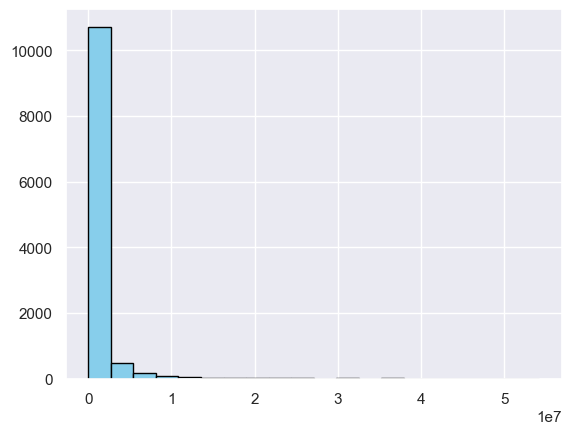

In [32]:
plt.hist(df_anime['score'], bins=20, color='skyblue', edgecolor='black')
plt.show()

apply a logaritmic trasnformation to normalise the values

In [ ]:
df_anime['score'] = np.log(df_anime['score'])

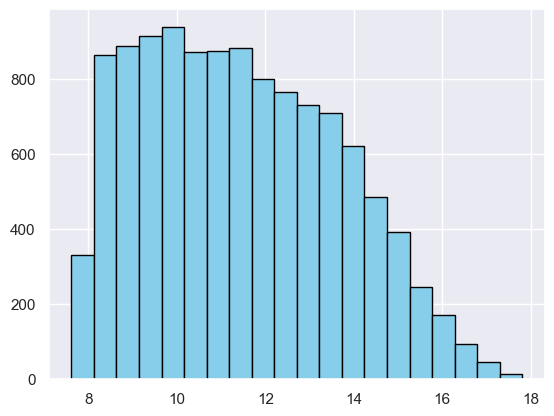

In [34]:
plt.hist(df_anime['score'], bins=20, color='skyblue', edgecolor='black')
plt.show()

final score is created by divide score by its maximum value and multipling by 10 (so that the result is a number between 0 and 10)

In [ ]:
df_anime['final_score'] = 10 * df_anime['score']/df_anime['score'].max()

create a final_score related fields: anime quality

In [ ]:
def calculate_nps(row:float) -> str:
    """Function to calculate some kind of NPS (net promoted score) of an anime based on the final score
    Args:
        row (float): final score of the anime
    Returns:
        str: NPS category
    """
    score = row['final_score']
    if score >= 9:
        nps = 'excellent'
    elif score >= 7:
        nps = 'good'
    else:
        nps = 'bad'
    return nps
df_anime['anime_quality'] = df_anime.apply(lambda row: calculate_nps(row), axis=1)

check anime_quality distribution

In [38]:
df_anime['anime_quality'].value_counts()

anime_quality
bad          7758
good         3655
excellent     220
Name: count, dtype: int64

check the top 20 anime based on final_score to evaluate if it could be a good KPI

In [39]:
df_anime[df_anime['anime_quality'].isin(['excellent'])].sort_values('final_score', ascending=False).head(20)

,_id,title,start_date,end_date,vote,rank,num_scoring_users,updated_at,media_type,status,...,completed,on_hold,dropped,plan_to_watch,main_genres,inspired_by,min_age,score,final_score,anime_quality
3326,16498,Attack on Titan,2013-04-07,2013-09-29,8.55,106,2813984,2023-12-09,tv,finished_airing,...,3484507,51357,61049,172682,"[Action, Adventure, Drama, Horror, Suspence]",manga,18,17.807853,10.000000,excellent
590,1535,Death Note,2006-10-04,2007-06-27,8.62,82,2762215,2024-03-06,tv,finished_airing,...,3267530,109785,119799,235526,"[Suspence, Adventure, Sci-Fi]",manga,18,17.781634,9.985277,excellent
2413,30276,One Punch Man,2015-10-05,2015-12-21,8.49,137,2248888,2023-01-13,tv,finished_airing,...,2828272,44687,40949,186865,"[Action, Romantic, Comedy, Fantasy]",manga,18,17.590189,9.877770,excellent
6559,5114,Fullmetal Alchemist: Brotherhood,2009-04-05,2010-07-04,9.09,2,2132852,2023-04-02,tv,finished_airing,...,2433582,113182,59759,499441,"[Action, Adventure, Drama, Fantasy]",manga,18,17.579027,9.871502,excellent
168,38000,Demon Slayer: Kimetsu no Yaiba,2019-04-06,2019-09-28,8.46,152,2111740,2023-04-02,tv,finished_airing,...,2569174,43492,42264,184528,"[Action, Adventure, Fantasy, Drama]",manga,18,17.522847,9.839954,excellent
4318,31964,My Hero Academia,2016-04-03,2016-06-26,7.86,853,2079366,2023-04-02,tv,finished_airing,...,2663911,30162,42194,171363,"[Action, Kids, Adventure, Fantasy]",manga,13,17.488024,9.820400,excellent
4576,11757,Sword Art Online,2012-07-08,2012-12-23,7.21,3165,2157893,2022-12-30,tv,finished_airing,...,2645081,36462,127810,165822,"[Action, Adventure, Fantasy, Romantic]",novel,13,17.463245,9.806485,excellent
6494,32281,Your Name.,2016-08-26,2016-08-26,8.84,27,1914945,2023-10-30,movie,finished_airing,...,2390660,7206,3934,297103,"[Adventure, Drama, Romantic, Sci-Fi]",original,13,17.444126,9.795749,excellent
183,25777,Attack on Titan Season 2,2017-04-01,2017-06-17,8.52,121,1879724,2023-01-13,tv,finished_airing,...,2452045,17707,16364,164742,"[Action, Drama, Horror, Adventure, Suspence]",manga,18,17.424670,9.784823,excellent
3107,20,Naruto,2002-10-03,2007-02-08,8.00,642,1984563,2024-04-07,tv,finished_airing,...,2331453,92811,132075,104957,"[Action, Adventure, Fantasy]",manga,13,17.422119,9.783391,excellent


extract the genres list, create a dictionary with the mapping genre_id-anime_ids and save them into a csv file

In [40]:
genres_list = []
for row, _ in df_anime.iterrows():
    if row < df_anime.shape[0]:
        for genre in df_anime.iloc[row]['main_genres']:
            genres_list.append(genre)
genres_list = list(set(genres_list))

In [45]:
genres_jsons = []
for index, genre in enumerate(genres_list):
    genres_dict = {}
    genres_dict['_id'] = str(index)
    genres_dict['name'] = genre
    genres_dict['anime_id'] = []
    for row, _ in df_anime.iterrows():
        if row < df_anime.shape[0]:
            for gen in df_anime.iloc[row]['main_genres']:
                if gen == genre:
                    genres_dict['anime_id'].append(str(df_anime.iloc[row]['_id']))
    genres_jsons.append(genres_dict)

In [ ]:
genres_list = []
for genre in genres_jsons:
    genre_dict = {}
    genre_dict['genre_id'] = genre['_id']
    genre_dict['name'] = genre['name']
    genres_list.append(genre_dict.copy())
pd.DataFrame(genres_list).to_csv('../data/prod/genres.csv', index=False)

In [47]:
genre_for_df = []
for genre in genres_jsons:
    gen = {}
    gen['genre_id'] = genre['_id']
    for anime_id in genre['anime_id']:
        gen['anime_id'] = anime_id
        genre_for_df.append(gen.copy())
pd.DataFrame(genre_for_df).to_csv('../data/prod/anime_genres.csv', index=False)

apply the same functionality to the studios

In [51]:
studios_list = []
for row, _ in df_anime.iterrows():
    if row < df_anime.shape[0]:
        for studio in df_anime.iloc[row]['studios']:
            studios_list.append(studio)
studios_list = list(set(studios_list))

In [56]:
studios_jsons = []
for index, studio in enumerate(studios_list):
    studios_dict = {}
    studios_dict['studio_id'] = str(index)
    studios_dict['name'] = studio
    studios_jsons.append(studios_dict)
pd.DataFrame(studios_jsons).to_csv('../data/prod/studios.csv', index=False)

In [58]:
anime_studios = []
for studio in studios_jsons:
    studios_dict = {}
    studios_dict['studio_id'] = studio['studio_id']
    studios_dict['anime_id'] = []
    for row, _ in df_anime.iterrows():
        if row < df_anime.shape[0]:
            for stu in df_anime.iloc[row]['studios']:
                if stu == studio['name']:
                    studios_dict['anime_id'].append(str(df_anime.iloc[row]['_id']))
    anime_studios.append(studios_dict)

In [64]:
studio_for_df = []
for studio in anime_studios:
    stu = {}
    stu['studio_id'] = studio['studio_id']
    for anime_id in studio['anime_id']:
        stu['anime_id'] = anime_id
        studio_for_df.append(stu.copy())
df_studios = pd.DataFrame(studio_for_df)
df_studios.to_csv('../data/prod/anime_studios.csv', index=False)

drop useless columns

In [ ]:
df_anime.drop(columns = ['synopsis','vote', 'rank', 'genres', 'source', 'audience_rating', 'studios', 'score', 'main_genres'],
    axis = 1,
    inplace = True
)

save anime data into a csv file

In [80]:
df_anime.to_csv('../data/fact/anime.csv', index = False)